In [84]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm.notebook import tqdm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from IPython.display import HTML

plt.rcParams["figure.dpi"] = 100

In [2]:
df = pd.read_csv("Cars93.csv")
# la primera columna es literalmente el index. Se remueve.
df = df.drop(df.columns[0], axis=1)

# Exploración de variables

Hay tres columnas de "precio". Según [este](https://stat.ethz.ch/R-manual/R-devel/library/MASS/html/Cars93.html) artículo (ya que el link de brightspace no funcionaba), no creo que nos interesen las siguientes columnas:

* `Model` y `Make`: todos son distintos, nada que concluír
* `Min.Price` y `Max.Price`: se usará Price (el promedio de éstos dos)

In [3]:
df = df.drop(["Model","Make","Min.Price","Max.Price"],axis=1)

In [4]:
df.sort_values("Price",ascending=False).head()

,Manufacturer,Type,Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,EngineSize,Horsepower,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin
58,Mercedes-Benz,Midsize,61.9,19,25,Driver & Passenger,Rear,6,3.2,217,...,18.5,5,187,110,69,37,27.0,15.0,3525,non-USA
47,Infiniti,Midsize,47.9,17,22,Driver only,Rear,8,4.5,278,...,22.5,5,200,113,72,42,29.0,15.0,4000,non-USA
10,Cadillac,Midsize,40.1,16,25,Driver & Passenger,Front,8,4.6,295,...,20.0,5,204,111,74,44,31.0,14.0,3935,USA
18,Chevrolet,Sporty,38.0,17,25,Driver only,Rear,8,5.7,300,...,20.0,2,179,96,74,43,NaN,NaN,3380,USA
3,Audi,Midsize,37.7,19,26,Driver & Passenger,Front,6,2.8,172,...,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA


Campos con datos faltantes

In [5]:
null_fields = df.isnull().sum()
null_fields[null_fields != 0]

Rear.seat.room     2
Luggage.room      11
dtype: int64

## tipos de dato de cada variable

De la documentación sabemos que `Cylinders` es realmente numérica (con un dato especial que es `'rotary'`), y `Man.trans.avail` es booleana.

In [6]:
df['Cylinders'] = df['Cylinders'].str.replace('rotary',"nan").apply(float)

In [7]:
columns = df.keys()
types = [type(df[key].iloc[0]).__name__ for key in columns]
column_types_df = pd.DataFrame(zip(columns,types),columns=["field","type"])
ini = "<div style='float:left; margin:10px'>"
HTML(ini + f"</div>{ini}".join([pd.DataFrame({key:val["field"]}).to_html() for key,val in column_types_df.groupby("type")]))

,float64
2,Price
7,Cylinders
8,EngineSize
13,Fuel.tank.capacity
19,Rear.seat.room
20,Luggage.room
,int64
3,MPG.city
4,MPG.highway
9,Horsepower


Son 16 varaibles numéricas, excluyendo `Price`

In [8]:
numeric_columns = column_types_df[column_types_df["type"] != "str"]["field"]
numeric_columns = numeric_columns[numeric_columns != "Price"].values
len(numeric_columns)

16

In [9]:
field_mat = np.reshape(numeric_columns,(4,4))

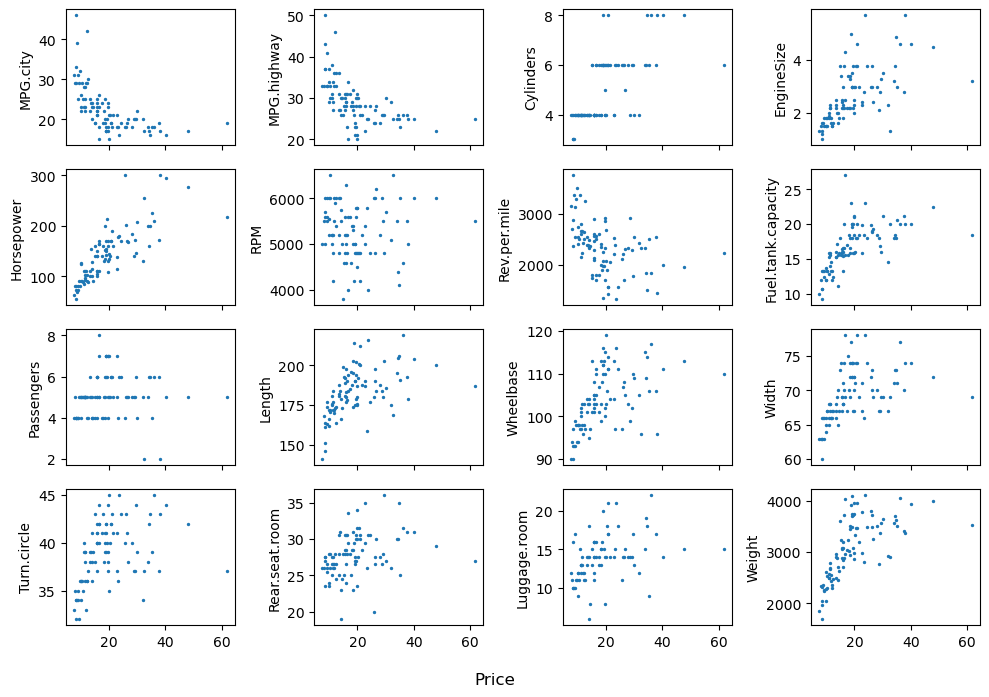

In [10]:
fig, ax = plt.subplots(4,4,sharex=True,figsize=(10,7))

for ij in np.ndindex(4,4):
    plt.sca(ax[ij])
    plt.scatter(df.Price,df[field_mat[ij]],s=2)
    plt.ylabel(field_mat[ij])
    
fig.supxlabel('Price')
plt.tight_layout()

Y 6 varaibles textuales

In [11]:
string_columns = column_types_df[column_types_df["type"] == "str"]["field"].values
len(string_columns)

6

In [12]:
field_mat = np.reshape(string_columns,(2,3))

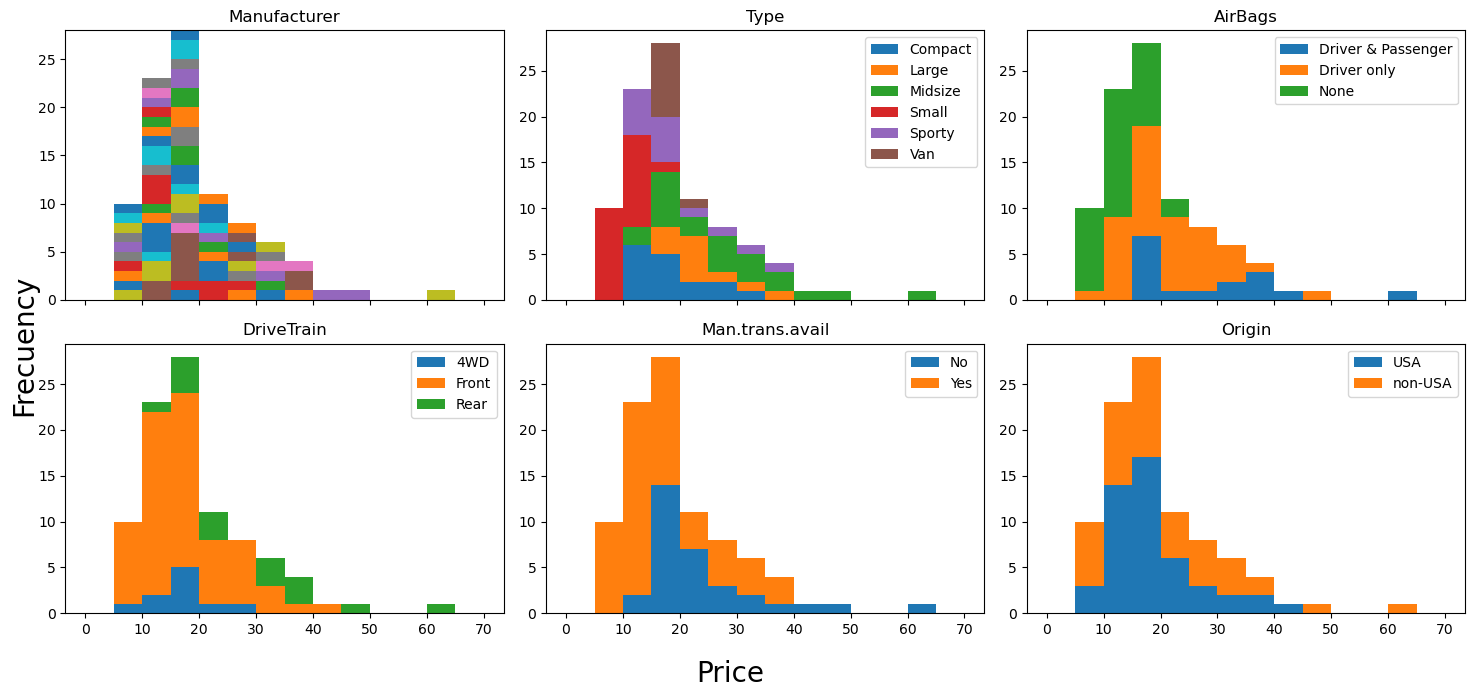

In [13]:
fig,ax = plt.subplots(2,3,sharex=True,figsize=(15,7))

for ij in np.ndindex(2,3):
    
    col = field_mat[ij]
    
    pd.DataFrame(
        {key:np.pad(val.Price.values,(0,93-len(val.Price.values)),'constant',constant_values=np.nan) for key,val in df.groupby(col)}
    ).plot.hist(stacked=True,ax=ax[ij],legend=(col != "Manufacturer"),bins=np.arange(0,75,5))
    ax[ij].set_title(col)
    ax[ij].set_ylabel("")
    
fig.supxlabel("Price",fontsize=20)
fig.supylabel("Frecuency",fontsize=20)
plt.tight_layout()

ciertamente hay una relación entre estas variables textuales y el precio (excepto en el caso de `Manufacturer`). Las variables booleanas (`Origin` y `Man.trans.avail`) se pondrán como 0 y 1, y los Airbags se pondrán como 0 (None), 1 (driver only) y 2 (driver & passenger). Mirando el historgama de precios, se decidirá que en `DriveTrain` se reemplazará 4WD con 0, Front con 1 y Rear con 2.

In [14]:
df["DriveTrain"] = df["DriveTrain"].str.replace("4WD","0").str.replace("Front","1").str.replace("Rear","2").apply(int)

In [15]:
df["AirBags"] = df["AirBags"].str.replace("None","0").str.replace("Driver only","1").str.replace("Driver & Passenger","2").apply(int)

In [16]:
df["Man.trans.avail"] = (df["Man.trans.avail"] == "Yes")*1

In [17]:
df["Origin"] = (df["Origin"] == "USA")*1

Quizás sea buena idea considerar el tipo de auto. No sé cómo volver eso numérico sin inducir un bias de orden ("sporty" no es necesariametne más grande que "compact", ni más pequeño) así que probaré con una columna booleana para cada tipo de carro: una columna "Sporty" que marque 1 si es sporty y otra que no

> (spoiler alert, no funcionó. Queda comentado)

In [18]:
#df_bool_type = pd.DataFrame({typ:(df["Type"]==typ)*1 for typ in  np.unique(df["Type"])}) # esta no me la sabía: booleanizar variables categóricas
#df = pd.concat([df,df_bool_type],axis=1) 

Y el precio se ha de catalogar como entero: columna de "clase de precio", 0,1,2 si es barato, medio o caro respectivamente. Estos límites de barato medio o caro se sacaron mirando el histograma de precios

In [49]:
def catalogar_precio(precio):
    return 0 if precio < 20 else 1 if precio < 400 else 2 # barato, medio o caro

In [50]:
df["Price_classes"] = df["Price"].apply(catalogar_precio)

Ahora los tipos son

In [51]:
columns = df.keys()
types = [type(df[key].iloc[0]).__name__ for key in columns]
column_types_df = pd.DataFrame(zip(columns,types),columns=["field","type"])
ini = "<div style='float:left; margin:10px'>"
HTML(ini + f"</div>{ini}".join([pd.DataFrame({key:val["field"]}).to_html() for key,val in column_types_df.groupby("type")]))

,float64
2,Price
7,Cylinders
8,EngineSize
13,Fuel.tank.capacity
19,Rear.seat.room
20,Luggage.room
,int64
3,MPG.city
4,MPG.highway
5,AirBags


Eso significa que todas las variables excepto las dos textuales que quedan serán usadas en el análisis, y las columnas de precio original y float

In [52]:
train_columns = np.array([key for key in df.keys() if key not in ["Price","Price_classes","Manufacturer","Type"]])

Debido a que el score varía de clasificador a clasificador, se elegirá el mejor score de 500 árboles

In [93]:
models = []
for i in tqdm(range(500)):
    model = RandomForestClassifier()
    
    X = df[train_columns].fillna(0).values
    Y = df["Price_classes"].values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,stratify=Y)
    
    models.append(model.fit(X_train,Y_train))

  0%|          | 0/500 [00:00<?, ?it/s]

In [97]:
best_model = max(models,key=lambda t:t.score(X_test,Y_test))
best_model.score(X_test,Y_test)

1.0

In [98]:
importances = model.feature_importances_
indices = np.flip(np.argsort(importances))[:4]

pd.DataFrame(np.array([train_columns[indices],np.round(100*importances[indices],decimals=2)]).T,columns=["Variable","% importance"])

,Variable,% importance
0,Horsepower,20.49
1,Fuel.tank.capacity,11.55
2,MPG.city,8.73
3,MPG.highway,7.25


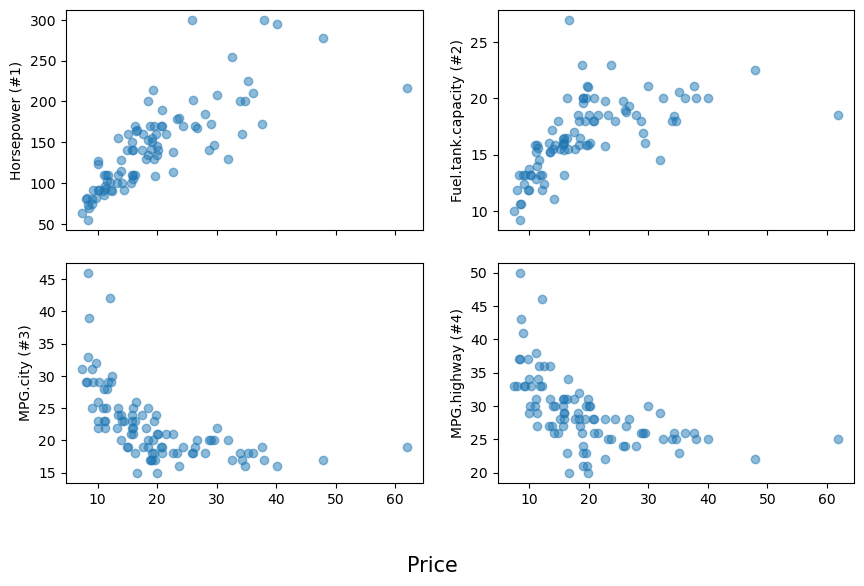

In [104]:
important_columns = np.array(train_columns)[indices]

fig, axes = plt.subplots(2,2,sharex=True,figsize=(9,6))

for i,ax in enumerate(np.ravel(axes)):
    plt.sca(ax)
    plt.scatter(df["Price"],df[important_columns[i]],alpha=0.5)
    plt.ylabel(f"{important_columns[i]} (#{i+1})")

fig.supxlabel('Price',fontsize=15)
plt.tight_layout(pad=2)